In [3]:
%run test.py


PyTorch version: 2.7.1
Using device: mps
Training steps: 640
Total synthetic samples processed: 163840
Elapsed time: 1.50s
Throughput: 108961 samples/s


In [4]:
%run Desktop/code/test.py


Exception: File `'Desktop/code/test.py'` not found.

In [ ]:
#!/usr/bin/env python3
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
PyBullet 3-DoF 机械臂 + 圆形轨道底座（GUI + 滑块/键盘并存）

用法：
  conda activate bullet312
  python test_environment.py

操作：
  - 滑块：窗口右侧 User Parameters 面板 J1/J2/J3。
  - 机械臂关节键盘控制（窗口需有焦点）：
      J1：I/K 或 ←/→
      J2：J/L 或 ↑/↓
      J3：U/O 或 PageUp/PageDown
    支持"按住连续变化"和"点按步进"(5°/次)。
  
  - 🆕 轨道底座控制：
      Q：逆时针旋转（沿轨道移动）
      P：顺时针旋转（沿轨道移动）

说明：
  - 机械臂基座安装在圆形轨道上，可以沿轨道旋转移动
  - 轨道半径：0.5 米
  - 键盘采用"角速度积分 + 点按步进"的双机制
  - 滑块与键盘并存：只有当滑块真的移动（超过 0.2°）时，才覆盖目标角度
"""

import os
import time
import math
import tempfile
import pybullet as p
import pybullet_data

URDF_TEMPLATE = """
<?xml version="1.0"?>
<robot name="three_dof_arm">
  <link name="base_link">
    <inertial><origin xyz="0 0 0"/><mass value="1"/><inertia ixx="0.001" iyy="0.001" izz="0.001" ixy="0" ixz="0" iyz="0"/></inertial>
    <visual><origin xyz="0 0 0"/><geometry><box size="0.12 0.12 0.06"/></geometry><material name="grey"><color rgba="0.7 0.7 0.7 1"/></material></visual>
    <collision><origin xyz="0 0 0"/><geometry><box size="0.12 0.12 0.06"/></geometry></collision>
  </link>

  <joint name="joint1" type="revolute">
    <parent link="base_link"/><child link="link1"/>
    <origin xyz="0 0 0.03"/><axis xyz="0 0 1"/>
    <limit lower="-3.14159" upper="3.14159" effort="20" velocity="6"/>
    <dynamics damping="0.02" friction="0.0"/>
  </joint>
  <link name="link1">
    <inertial><origin xyz="0 0 0.11"/><mass value="0.4"/><inertia ixx="0.002" iyy="0.002" izz="0.002" ixy="0" ixz="0" iyz="0"/></inertial>
    <visual><origin xyz="0 0 0.11"/><geometry><box size="0.04 0.04 0.22"/></geometry><material name="blue"><color rgba="0.2 0.4 0.9 1"/></material></visual>
    <collision><origin xyz="0 0 0.11"/><geometry><box size="0.04 0.04 0.22"/></geometry></collision>
  </link>

  <joint name="joint2" type="revolute">
    <parent link="link1"/><child link="link2"/>
    <origin xyz="0 0 0.22"/><axis xyz="0 1 0"/>
    <limit lower="-1.745" upper="1.745" effort="20" velocity="6"/>
    <dynamics damping="0.02" friction="0.0"/>
  </joint>
  <link name="link2">
    <inertial><origin xyz="0.09 0 0"/><mass value="0.35"/><inertia ixx="0.002" iyy="0.002" izz="0.002" ixy="0" ixz="0" iyz="0"/></inertial>
    <visual><origin xyz="0.09 0 0"/><geometry><box size="0.18 0.035 0.035"/></geometry><material name="orange"><color rgba="0.95 0.55 0.2 1"/></material></visual>
    <collision><origin xyz="0.09 0 0"/><geometry><box size="0.18 0.035 0.035"/></geometry></collision>
  </link>

  <joint name="joint3" type="revolute">
    <parent link="link2"/><child link="link3"/>
    <origin xyz="0.18 0 0"/><axis xyz="0 1 0"/>
    <limit lower="-2.094" upper="2.094" effort="20" velocity="6"/>
    <dynamics damping="0.02" friction="0.0"/>
  </joint>
  <link name="link3">
    <inertial><origin xyz="0.08 0 0"/><mass value="0.3"/><inertia ixx="0.002" iyy="0.002" izz="0.002" ixy="0" ixz="0" iyz="0"/></inertial>
    <visual><origin xyz="0.08 0 0"/><geometry><box size="0.16 0.03 0.03"/></geometry><material name="green"><color rgba="0.2 0.8 0.4 1"/></material></visual>
    <collision><origin xyz="0.08 0 0"/><geometry><box size="0.16 0.03 0.03"/></geometry></collision>
  </link>

  <joint name="ee_fixed" type="fixed"><parent link="link3"/><child link="ee"/><origin xyz="0.16 0 0"/></joint>
  <link name="ee">
    <visual><origin xyz="0 0 0"/><geometry><box size="0.03 0.03 0.03"/></geometry><material name="red"><color rgba="0.9 0.2 0.2 1"/></material></visual>
    <collision><origin xyz="0 0 0"/><geometry><box size="0.03 0.03 0.03"/></geometry></collision>
  </link>
</robot>
"""


def write_urdf_tmp(text: str) -> str:
    tmpdir = tempfile.mkdtemp(prefix="arm3dof_")
    urdf_path = os.path.join(tmpdir, "arm3dof.urdf")
    with open(urdf_path, "w", encoding="utf-8") as f:
        f.write(text)
    return urdf_path


def main() -> None:
    try:
        p.connect(p.GUI)
    except Exception:
        p.connect(p.DIRECT)

    p.setAdditionalSearchPath(pybullet_data.getDataPath())
    p.resetSimulation()
    p.setPhysicsEngineParameter(enableFileCaching=0)
    p.setGravity(0, 0, -9.81)
    p.resetDebugVisualizerCamera(cameraDistance=1.8, cameraYaw=40, cameraPitch=-35,
                                 cameraTargetPosition=[0.0, 0.0, 0.15])
    try:
        p.configureDebugVisualizer(p.COV_ENABLE_GUI, 1)
    except Exception:
        pass

    p.loadURDF("plane.urdf")

    # ====== 创建圆形轨道底座 ======
    track_radius = 0.5  # 轨道半径 0.5 米
    track_width = 0.08
    track_height = 0.05
    
    # 轨道环（可视化）
    track_visual = p.createVisualShape(
        p.GEOM_CYLINDER,
        radius=track_radius,
        length=track_height,
        rgbaColor=[0.3, 0.3, 0.3, 0.6]
    )
    track_collision = p.createCollisionShape(
        p.GEOM_CYLINDER,
        radius=track_radius,
        height=track_height
    )
    track_id = p.createMultiBody(
        baseMass=0,
        baseCollisionShapeIndex=track_collision,
        baseVisualShapeIndex=track_visual,
        basePosition=[0, 0, track_height/2],
        baseOrientation=p.getQuaternionFromEuler([0, 0, 0])
    )
    
    # 轨道内圈（遮挡，营造"环形"效果）
    inner_radius = track_radius - track_width
    inner_visual = p.createVisualShape(
        p.GEOM_CYLINDER,
        radius=inner_radius,
        length=track_height + 0.001,
        rgbaColor=[0.5, 0.5, 0.5, 1.0]
    )
    inner_collision = p.createCollisionShape(
        p.GEOM_CYLINDER,
        radius=inner_radius,
        height=track_height + 0.001
    )
    p.createMultiBody(
        baseMass=0,
        baseCollisionShapeIndex=inner_collision,
        baseVisualShapeIndex=inner_visual,
        basePosition=[0, 0, track_height/2],
        baseOrientation=p.getQuaternionFromEuler([0, 0, 0])
    )
    
    # 轨道位置角度（弧度）
    track_angle = 0.0  # 机械臂在轨道上的角度位置
    
    # 计算机械臂基座初始位置
    arm_x = track_radius * math.cos(track_angle)
    arm_y = track_radius * math.sin(track_angle)
    arm_z = track_height  # 放在轨道上方
    
    # ====== 加载机械臂（放在轨道上） ======
    urdf_path = write_urdf_tmp(URDF_TEMPLATE)
    arm_id = p.loadURDF(
        urdf_path, 
        basePosition=[arm_x, arm_y, arm_z], 
        baseOrientation=p.getQuaternionFromEuler([0, 0, track_angle]),
        useFixedBase=False,  # 改为非固定，但我们会手动控制位置
        flags=p.URDF_USE_SELF_COLLISION
    )
    assert isinstance(arm_id, int), "arm_id not set"
    print(f"arm_id={arm_id}")

    num_joints = p.getNumJoints(arm_id)
    print(f"num_joints={num_joints}")
    control_joints = [0, 1, 2]

    # 坐标轴辅助（固定在世界坐标）
    p.addUserDebugLine([0, 0, 0], [0.3, 0, 0], [1, 0, 0], lineWidth=3)
    p.addUserDebugLine([0, 0, 0], [0, 0.3, 0], [0, 1, 0], lineWidth=3)
    p.addUserDebugLine([0, 0, 0], [0, 0, 0.3], [0, 0, 1], lineWidth=3)

    # 叶片示意
    leaf_thickness = 0.004
    leaf_half_extents = [0.12, 0.08, leaf_thickness / 2]
    leaf_vis = p.createVisualShape(p.GEOM_BOX, halfExtents=leaf_half_extents, rgbaColor=[0.2, 0.7, 0.2, 1])
    leaf_col = p.createCollisionShape(p.GEOM_BOX, halfExtents=leaf_half_extents)
    p.createMultiBody(baseMass=0, baseCollisionShapeIndex=leaf_col, baseVisualShapeIndex=leaf_vis,
                      basePosition=[0.35, 0.0, 0.35], baseOrientation=p.getQuaternionFromEuler([0, 0.0, 0]))

    # 降低阻尼，提响应
    for link in range(-1, num_joints):
        try:
            p.changeDynamics(arm_id, link, linearDamping=0.0, angularDamping=0.0)
        except Exception:
            pass
    
    # 固定机械臂基座（防止重力影响）
    p.changeDynamics(arm_id, -1, mass=10, linearDamping=0, angularDamping=0)

    # 演示 3 秒（机械臂动作 + 轨道移动）
    print("演示模式：机械臂挥舞 + 轨道旋转...")
    t0 = time.time()
    while time.time() - t0 < 3.0:
        t = time.time() - t0
        q1 = math.radians(20.0 * math.sin(1.5 * t))
        q2 = math.radians(30.0 + 15.0 * math.sin(1.7 * t))
        q3 = math.radians(40.0 * math.sin(2.0 * t))
        p.setJointMotorControlArray(arm_id, control_joints, p.POSITION_CONTROL,
                                    targetPositions=[q1, q2, q3], positionGains=[0.45]*3, forces=[40]*3)
        
        # 演示时轨道也缓慢旋转
        track_angle += 0.3 * (1/240)  # 约 17°/秒
        arm_x = track_radius * math.cos(track_angle)
        arm_y = track_radius * math.sin(track_angle)
        p.resetBasePositionAndOrientation(
            arm_id,
            [arm_x, arm_y, arm_z],
            p.getQuaternionFromEuler([0, 0, track_angle])
        )
        
        p.stepSimulation()
        time.sleep(1/240)

    # 创建滑块
    slider_ids = []
    try:
        slider_ids = [
            p.addUserDebugParameter("J1 yaw (deg)", -180, 180, 0),
            p.addUserDebugParameter("J2 pitch (deg)", -100, 100, 30),
            p.addUserDebugParameter("J3 pitch (deg)", -120, 120, 45),
        ]
        time.sleep(0.2)
        print("Slider IDs:", slider_ids)
    except Exception as e:
        print("[Warn] Failed to create sliders:", e)

    # 实时仿真，提升交互
    try:
        p.setRealTimeSimulation(1)
    except Exception:
        pass

    print("Switch to interactive control.")
    print("[Hint] 机械臂关节: J1(I/K or ←/→), J2(J/L or ↑/↓), J3(U/O or PgUp/PgDn)")
    print("[Hint] 🆕 轨道移动: Q=逆时针, P=顺时针")
    print("[Hint] Debug: press 'H' to toggle key logging, 'T' to print track angle")

    # 目标角度（度），优先用滑块初值
    def read_slider_vals():
        vals = []
        for sid in slider_ids:
            try:
                vals.append(p.readUserDebugParameter(sid))
            except Exception:
                return None
        return vals if len(vals) == 3 and all(v is not None for v in vals) else None

    q_deg = read_slider_vals() or [0.0, 30.0, 45.0]
    last_slider = q_deg[:]

    # 键盘角速度（deg/s）与点按步进
    rate_unit = 120.0           # 按住时的角速度
    tap_step = 5.0              # 点按一次的步进
    limits_lo = [-180.0, -100.0, -120.0]
    limits_hi = [ 180.0,  100.0,  120.0]
    
    # 轨道旋转速度（rad/s）
    track_rotation_speed = 0.5  # 约 28.6°/秒
    track_tap_step = math.radians(10)  # 点按一次旋转 10°

    # 调试开关
    key_log = False

    # 工具：检测按住/点按（ASCII 与特殊键）
    def _down_ascii(keys, ch):
        code1, code2 = ord(ch.lower()), ord(ch.upper())
        v1, v2 = keys.get(code1, 0), keys.get(code2, 0)
        return (v1 & p.KEY_IS_DOWN) or (v2 & p.KEY_IS_DOWN)

    def _hit_ascii(keys, ch):
        code1, code2 = ord(ch.lower()), ord(ch.upper())
        v1, v2 = keys.get(code1, 0), keys.get(code2, 0)
        return (v1 & p.KEY_WAS_TRIGGERED) or (v2 & p.KEY_WAS_TRIGGERED)

    def _down_code(keys, code):
        v = keys.get(code, 0)
        return (v & p.KEY_IS_DOWN)

    def _hit_code(keys, code):
        v = keys.get(code, 0)
        return (v & p.KEY_WAS_TRIGGERED)

    prev_t = time.time()

    while p.isConnected():
        now = time.time()
        dt = max(1e-3, min(0.05, now - prev_t))
        prev_t = now

        # 若滑块被移动（超过阈值），覆盖目标
        vals = read_slider_vals()
        if vals is not None and any(abs(v - ls) > 0.2 for v, ls in zip(vals, last_slider)):
            q_deg = vals[:]
            last_slider = vals[:]

        keys = p.getKeyboardEvents()

        # 调试：按 H 开关日志，按 T 打印轨道角度
        if _hit_ascii(keys, 'h'):
            key_log = not key_log
            print("[KeyLog]", "ON" if key_log else "OFF")
        if _hit_ascii(keys, 't'):
            js = [p.getJointState(arm_id, i)[0] for i in control_joints]
            print(f"[Track angle] {math.degrees(track_angle):.1f}°")
            print(f"[Joints rad] {[round(x,3) for x in js]}")

        if key_log and keys:
            # 仅打印触发事件，避免刷屏
            ev = {k:int(v) for k,v in keys.items() if v & (p.KEY_WAS_TRIGGERED|p.KEY_IS_DOWN)}
            if ev:
                print("[Keys]", ev)

        rate = [0.0, 0.0, 0.0]
        track_rate = 0.0  # 轨道旋转速度

        # ====== 轨道控制（Q/P键）======
        # Q：逆时针旋转（增加角度）
        if _down_ascii(keys, 'q'):
            track_rate += track_rotation_speed
        if _hit_ascii(keys, 'q'):
            track_angle += track_tap_step
        
        # P：顺时针旋转（减少角度）
        if _down_ascii(keys, 'p'):
            track_rate -= track_rotation_speed
        if _hit_ascii(keys, 'p'):
            track_angle -= track_tap_step

        # J1：I/K 或 ←/→（移除了A/D，让给轨道）
        if _down_ascii(keys, 'i') or _down_code(keys, p.B3G_RIGHT_ARROW):
            rate[0] += rate_unit
        if _down_ascii(keys, 'k') or _down_code(keys, p.B3G_LEFT_ARROW):
            rate[0] -= rate_unit
        if _hit_ascii(keys, 'i') or _hit_code(keys, p.B3G_RIGHT_ARROW):
            q_deg[0] += tap_step
        if _hit_ascii(keys, 'k') or _hit_code(keys, p.B3G_LEFT_ARROW):
            q_deg[0] -= tap_step

        # J2：J/L 或 W/S 或 ↑/↓
        if _down_ascii(keys, 'j') or _down_ascii(keys, 'w') or _down_code(keys, p.B3G_UP_ARROW):
            rate[1] += rate_unit
        if _down_ascii(keys, 'l') or _down_ascii(keys, 's') or _down_code(keys, p.B3G_DOWN_ARROW):
            rate[1] -= rate_unit
        if _hit_ascii(keys, 'j') or _hit_ascii(keys, 'w') or _hit_code(keys, p.B3G_UP_ARROW):
            q_deg[1] += tap_step
        if _hit_ascii(keys, 'l') or _hit_ascii(keys, 's') or _hit_code(keys, p.B3G_DOWN_ARROW):
            q_deg[1] -= tap_step

        # J3：U/O 或 E（移除了Q，让给轨道）或 PgUp/PgDn
        if _down_ascii(keys, 'u') or _down_ascii(keys, 'e') or _down_code(keys, p.B3G_PAGE_UP):
            rate[2] += rate_unit
        if _down_ascii(keys, 'o') or _down_code(keys, p.B3G_PAGE_DOWN):
            rate[2] -= rate_unit
        if _hit_ascii(keys, 'u') or _hit_ascii(keys, 'e') or _hit_code(keys, p.B3G_PAGE_UP):
            q_deg[2] += tap_step
        if _hit_ascii(keys, 'o') or _hit_code(keys, p.B3G_PAGE_DOWN):
            q_deg[2] -= tap_step

        # 角速度积分 + 限位
        for i in range(3):
            q_deg[i] += rate[i] * dt
            q_deg[i] = max(limits_lo[i], min(limits_hi[i], q_deg[i]))
        
        # 轨道角度更新
        track_angle += track_rate * dt
        # 轨道角度归一化到 [-π, π]
        track_angle = (track_angle + math.pi) % (2 * math.pi) - math.pi
        
        # 更新机械臂基座位置（沿轨道移动）
        arm_x = track_radius * math.cos(track_angle)
        arm_y = track_radius * math.sin(track_angle)
        p.resetBasePositionAndOrientation(
            arm_id,
            [arm_x, arm_y, arm_z],
            p.getQuaternionFromEuler([0, 0, track_angle])
        )

        q_rad = [math.radians(v) for v in q_deg]
        p.setJointMotorControlArray(
            arm_id, control_joints, p.POSITION_CONTROL,
            targetPositions=q_rad,
            positionGains=[1.2, 1.2, 1.2],
            velocityGains=[0.6, 0.6, 0.6],
            forces=[180, 180, 180]
        )

        time.sleep(0.005)


if __name__ == "__main__":
    main()


In [5]:
%run test.py

PyTorch version: 2.7.1
Using device: mps
Training steps: 640
Total synthetic samples processed: 163840
Elapsed time: 1.50s
Throughput: 109324 samples/s


In [6]:
%run Desktop/code/test.py

Exception: File `'Desktop/code/test.py'` not found.

In [ ]:
#!/usr/bin/env python3
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
PyBullet 3-DoF 机械臂 + 圆形轨道底座（GUI + 滑块/键盘并存）

用法：
  conda activate bullet312
  python test_environment.py

操作：
  - 滑块：窗口右侧 User Parameters 面板 J1/J2/J3。
  - 机械臂关节键盘控制（窗口需有焦点）：
      J1：I/K 或 ←/→
      J2：J/L 或 ↑/↓
      J3：U/O 或 PageUp/PageDown
    支持"按住连续变化"和"点按步进"(5°/次)。
  
  - 🆕 轨道底座控制：
      Q：逆时针旋转（沿轨道移动）
      P：顺时针旋转（沿轨道移动）

说明：
  - 机械臂基座安装在圆形轨道上，可以沿轨道旋转移动
  - 轨道半径：0.5 米
  - 键盘采用"角速度积分 + 点按步进"的双机制
  - 滑块与键盘并存：只有当滑块真的移动（超过 0.2°）时，才覆盖目标角度
"""

import os
import time
import math
import tempfile
import pybullet as p
import pybullet_data

URDF_TEMPLATE = """
<?xml version="1.0"?>
<robot name="three_dof_arm">
  <link name="base_link">
    <inertial><origin xyz="0 0 0"/><mass value="1"/><inertia ixx="0.001" iyy="0.001" izz="0.001" ixy="0" ixz="0" iyz="0"/></inertial>
    <visual><origin xyz="0 0 0"/><geometry><box size="0.12 0.12 0.06"/></geometry><material name="grey"><color rgba="0.7 0.7 0.7 1"/></material></visual>
    <collision><origin xyz="0 0 0"/><geometry><box size="0.12 0.12 0.06"/></geometry></collision>
  </link>

  <joint name="joint1" type="revolute">
    <parent link="base_link"/><child link="link1"/>
    <origin xyz="0 0 0.03"/><axis xyz="0 0 1"/>
    <limit lower="-3.14159" upper="3.14159" effort="20" velocity="6"/>
    <dynamics damping="0.02" friction="0.0"/>
  </joint>
  <link name="link1">
    <inertial><origin xyz="0 0 0.11"/><mass value="0.4"/><inertia ixx="0.002" iyy="0.002" izz="0.002" ixy="0" ixz="0" iyz="0"/></inertial>
    <visual><origin xyz="0 0 0.11"/><geometry><box size="0.04 0.04 0.22"/></geometry><material name="blue"><color rgba="0.2 0.4 0.9 1"/></material></visual>
    <collision><origin xyz="0 0 0.11"/><geometry><box size="0.04 0.04 0.22"/></geometry></collision>
  </link>

  <joint name="joint2" type="revolute">
    <parent link="link1"/><child link="link2"/>
    <origin xyz="0 0 0.22"/><axis xyz="0 1 0"/>
    <limit lower="-1.745" upper="1.745" effort="20" velocity="6"/>
    <dynamics damping="0.02" friction="0.0"/>
  </joint>
  <link name="link2">
    <inertial><origin xyz="0.09 0 0"/><mass value="0.35"/><inertia ixx="0.002" iyy="0.002" izz="0.002" ixy="0" ixz="0" iyz="0"/></inertial>
    <visual><origin xyz="0.09 0 0"/><geometry><box size="0.18 0.035 0.035"/></geometry><material name="orange"><color rgba="0.95 0.55 0.2 1"/></material></visual>
    <collision><origin xyz="0.09 0 0"/><geometry><box size="0.18 0.035 0.035"/></geometry></collision>
  </link>

  <joint name="joint3" type="revolute">
    <parent link="link2"/><child link="link3"/>
    <origin xyz="0.18 0 0"/><axis xyz="0 1 0"/>
    <limit lower="-2.094" upper="2.094" effort="20" velocity="6"/>
    <dynamics damping="0.02" friction="0.0"/>
  </joint>
  <link name="link3">
    <inertial><origin xyz="0.08 0 0"/><mass value="0.3"/><inertia ixx="0.002" iyy="0.002" izz="0.002" ixy="0" ixz="0" iyz="0"/></inertial>
    <visual><origin xyz="0.08 0 0"/><geometry><box size="0.16 0.03 0.03"/></geometry><material name="green"><color rgba="0.2 0.8 0.4 1"/></material></visual>
    <collision><origin xyz="0.08 0 0"/><geometry><box size="0.16 0.03 0.03"/></geometry></collision>
  </link>

  <joint name="ee_fixed" type="fixed"><parent link="link3"/><child link="ee"/><origin xyz="0.16 0 0"/></joint>
  <link name="ee">
    <visual><origin xyz="0 0 0"/><geometry><box size="0.03 0.03 0.03"/></geometry><material name="red"><color rgba="0.9 0.2 0.2 1"/></material></visual>
    <collision><origin xyz="0 0 0"/><geometry><box size="0.03 0.03 0.03"/></geometry></collision>
  </link>
</robot>
"""


def write_urdf_tmp(text: str) -> str:
    tmpdir = tempfile.mkdtemp(prefix="arm3dof_")
    urdf_path = os.path.join(tmpdir, "arm3dof.urdf")
    with open(urdf_path, "w", encoding="utf-8") as f:
        f.write(text)
    return urdf_path


def main() -> None:
    try:
        p.connect(p.GUI)
    except Exception:
        p.connect(p.DIRECT)

    p.setAdditionalSearchPath(pybullet_data.getDataPath())
    p.resetSimulation()
    p.setPhysicsEngineParameter(enableFileCaching=0)
    p.setGravity(0, 0, -9.81)
    p.resetDebugVisualizerCamera(cameraDistance=1.8, cameraYaw=40, cameraPitch=-35,
                                 cameraTargetPosition=[0.0, 0.0, 0.15])
    try:
        p.configureDebugVisualizer(p.COV_ENABLE_GUI, 1)
    except Exception:
        pass

    p.loadURDF("plane.urdf")

    # ====== 创建圆形轨道底座 ======
    track_radius = 0.5  # 轨道半径 0.5 米
    track_width = 0.08
    track_height = 0.05
    
    # 轨道环（可视化）
    track_visual = p.createVisualShape(
        p.GEOM_CYLINDER,
        radius=track_radius,
        length=track_height,
        rgbaColor=[0.3, 0.3, 0.3, 0.6]
    )
    track_collision = p.createCollisionShape(
        p.GEOM_CYLINDER,
        radius=track_radius,
        height=track_height
    )
    track_id = p.createMultiBody(
        baseMass=0,
        baseCollisionShapeIndex=track_collision,
        baseVisualShapeIndex=track_visual,
        basePosition=[0, 0, track_height/2],
        baseOrientation=p.getQuaternionFromEuler([0, 0, 0])
    )
    
    # 轨道内圈（遮挡，营造"环形"效果）
    inner_radius = track_radius - track_width
    inner_visual = p.createVisualShape(
        p.GEOM_CYLINDER,
        radius=inner_radius,
        length=track_height + 0.001,
        rgbaColor=[0.5, 0.5, 0.5, 1.0]
    )
    inner_collision = p.createCollisionShape(
        p.GEOM_CYLINDER,
        radius=inner_radius,
        height=track_height + 0.001
    )
    p.createMultiBody(
        baseMass=0,
        baseCollisionShapeIndex=inner_collision,
        baseVisualShapeIndex=inner_visual,
        basePosition=[0, 0, track_height/2],
        baseOrientation=p.getQuaternionFromEuler([0, 0, 0])
    )
    
    # 轨道位置角度（弧度）
    track_angle = 0.0  # 机械臂在轨道上的角度位置
    
    # 计算机械臂基座初始位置
    arm_x = track_radius * math.cos(track_angle)
    arm_y = track_radius * math.sin(track_angle)
    arm_z = track_height  # 放在轨道上方
    
    # ====== 加载机械臂（放在轨道上） ======
    urdf_path = write_urdf_tmp(URDF_TEMPLATE)
    arm_id = p.loadURDF(
        urdf_path, 
        basePosition=[arm_x, arm_y, arm_z], 
        baseOrientation=p.getQuaternionFromEuler([0, 0, track_angle]),
        useFixedBase=False,  # 改为非固定，但我们会手动控制位置
        flags=p.URDF_USE_SELF_COLLISION
    )
    assert isinstance(arm_id, int), "arm_id not set"
    print(f"arm_id={arm_id}")

    num_joints = p.getNumJoints(arm_id)
    print(f"num_joints={num_joints}")
    control_joints = [0, 1, 2]

    # 坐标轴辅助（固定在世界坐标）
    p.addUserDebugLine([0, 0, 0], [0.3, 0, 0], [1, 0, 0], lineWidth=3)
    p.addUserDebugLine([0, 0, 0], [0, 0.3, 0], [0, 1, 0], lineWidth=3)
    p.addUserDebugLine([0, 0, 0], [0, 0, 0.3], [0, 0, 1], lineWidth=3)

    # 叶片示意
    leaf_thickness = 0.004
    leaf_half_extents = [0.12, 0.08, leaf_thickness / 2]
    leaf_vis = p.createVisualShape(p.GEOM_BOX, halfExtents=leaf_half_extents, rgbaColor=[0.2, 0.7, 0.2, 1])
    leaf_col = p.createCollisionShape(p.GEOM_BOX, halfExtents=leaf_half_extents)
    p.createMultiBody(baseMass=0, baseCollisionShapeIndex=leaf_col, baseVisualShapeIndex=leaf_vis,
                      basePosition=[0.35, 0.0, 0.35], baseOrientation=p.getQuaternionFromEuler([0, 0.0, 0]))

    # 降低阻尼，提响应
    for link in range(-1, num_joints):
        try:
            p.changeDynamics(arm_id, link, linearDamping=0.0, angularDamping=0.0)
        except Exception:
            pass
    
    # 固定机械臂基座（防止重力影响）
    p.changeDynamics(arm_id, -1, mass=10, linearDamping=0, angularDamping=0)

    # 演示 3 秒（机械臂动作 + 轨道移动）
    print("演示模式：机械臂挥舞 + 轨道旋转...")
    t0 = time.time()
    while time.time() - t0 < 3.0:
        t = time.time() - t0
        q1 = math.radians(20.0 * math.sin(1.5 * t))
        q2 = math.radians(30.0 + 15.0 * math.sin(1.7 * t))
        q3 = math.radians(40.0 * math.sin(2.0 * t))
        p.setJointMotorControlArray(arm_id, control_joints, p.POSITION_CONTROL,
                                    targetPositions=[q1, q2, q3], positionGains=[0.45]*3, forces=[40]*3)
        
        # 演示时轨道也缓慢旋转
        track_angle += 0.3 * (1/240)  # 约 17°/秒
        arm_x = track_radius * math.cos(track_angle)
        arm_y = track_radius * math.sin(track_angle)
        p.resetBasePositionAndOrientation(
            arm_id,
            [arm_x, arm_y, arm_z],
            p.getQuaternionFromEuler([0, 0, track_angle])
        )
        
        p.stepSimulation()
        time.sleep(1/240)

    # 创建滑块
    slider_ids = []
    try:
        slider_ids = [
            p.addUserDebugParameter("J1 yaw (deg)", -180, 180, 0),
            p.addUserDebugParameter("J2 pitch (deg)", -100, 100, 30),
            p.addUserDebugParameter("J3 pitch (deg)", -120, 120, 45),
        ]
        time.sleep(0.2)
        print("Slider IDs:", slider_ids)
    except Exception as e:
        print("[Warn] Failed to create sliders:", e)

    # 实时仿真，提升交互
    try:
        p.setRealTimeSimulation(1)
    except Exception:
        pass

    print("Switch to interactive control.")
    print("[Hint] 机械臂关节: J1(I/K or ←/→), J2(J/L or ↑/↓), J3(U/O or PgUp/PgDn)")
    print("[Hint] 🆕 轨道移动: Q=逆时针, P=顺时针")
    print("[Hint] Debug: press 'H' to toggle key logging, 'T' to print track angle")

    # 目标角度（度），优先用滑块初值
    def read_slider_vals():
        vals = []
        for sid in slider_ids:
            try:
                vals.append(p.readUserDebugParameter(sid))
            except Exception:
                return None
        return vals if len(vals) == 3 and all(v is not None for v in vals) else None

    q_deg = read_slider_vals() or [0.0, 30.0, 45.0]
    last_slider = q_deg[:]

    # 键盘角速度（deg/s）与点按步进
    rate_unit = 120.0           # 按住时的角速度
    tap_step = 5.0              # 点按一次的步进
    limits_lo = [-180.0, -100.0, -120.0]
    limits_hi = [ 180.0,  100.0,  120.0]
    
    # 轨道旋转速度（rad/s）
    track_rotation_speed = 0.5  # 约 28.6°/秒
    track_tap_step = math.radians(10)  # 点按一次旋转 10°

    # 调试开关
    key_log = False

    # 工具：检测按住/点按（ASCII 与特殊键）
    def _down_ascii(keys, ch):
        code1, code2 = ord(ch.lower()), ord(ch.upper())
        v1, v2 = keys.get(code1, 0), keys.get(code2, 0)
        return (v1 & p.KEY_IS_DOWN) or (v2 & p.KEY_IS_DOWN)

    def _hit_ascii(keys, ch):
        code1, code2 = ord(ch.lower()), ord(ch.upper())
        v1, v2 = keys.get(code1, 0), keys.get(code2, 0)
        return (v1 & p.KEY_WAS_TRIGGERED) or (v2 & p.KEY_WAS_TRIGGERED)

    def _down_code(keys, code):
        v = keys.get(code, 0)
        return (v & p.KEY_IS_DOWN)

    def _hit_code(keys, code):
        v = keys.get(code, 0)
        return (v & p.KEY_WAS_TRIGGERED)

    prev_t = time.time()

    while p.isConnected():
        now = time.time()
        dt = max(1e-3, min(0.05, now - prev_t))
        prev_t = now

        # 若滑块被移动（超过阈值），覆盖目标
        vals = read_slider_vals()
        if vals is not None and any(abs(v - ls) > 0.2 for v, ls in zip(vals, last_slider)):
            q_deg = vals[:]
            last_slider = vals[:]

        keys = p.getKeyboardEvents()

        # 调试：按 H 开关日志，按 T 打印轨道角度
        if _hit_ascii(keys, 'h'):
            key_log = not key_log
            print("[KeyLog]", "ON" if key_log else "OFF")
        if _hit_ascii(keys, 't'):
            js = [p.getJointState(arm_id, i)[0] for i in control_joints]
            print(f"[Track angle] {math.degrees(track_angle):.1f}°")
            print(f"[Joints rad] {[round(x,3) for x in js]}")

        if key_log and keys:
            # 仅打印触发事件，避免刷屏
            ev = {k:int(v) for k,v in keys.items() if v & (p.KEY_WAS_TRIGGERED|p.KEY_IS_DOWN)}
            if ev:
                print("[Keys]", ev)

        rate = [0.0, 0.0, 0.0]
        track_rate = 0.0  # 轨道旋转速度

        # ====== 轨道控制（Q/P键）======
        # Q：逆时针旋转（增加角度）
        if _down_ascii(keys, 'q'):
            track_rate += track_rotation_speed
        if _hit_ascii(keys, 'q'):
            track_angle += track_tap_step
        
        # P：顺时针旋转（减少角度）
        if _down_ascii(keys, 'p'):
            track_rate -= track_rotation_speed
        if _hit_ascii(keys, 'p'):
            track_angle -= track_tap_step

        # J1：I/K 或 ←/→（移除了A/D，让给轨道）
        if _down_ascii(keys, 'i') or _down_code(keys, p.B3G_RIGHT_ARROW):
            rate[0] += rate_unit
        if _down_ascii(keys, 'k') or _down_code(keys, p.B3G_LEFT_ARROW):
            rate[0] -= rate_unit
        if _hit_ascii(keys, 'i') or _hit_code(keys, p.B3G_RIGHT_ARROW):
            q_deg[0] += tap_step
        if _hit_ascii(keys, 'k') or _hit_code(keys, p.B3G_LEFT_ARROW):
            q_deg[0] -= tap_step

        # J2：J/L 或 W/S 或 ↑/↓
        if _down_ascii(keys, 'j') or _down_ascii(keys, 'w') or _down_code(keys, p.B3G_UP_ARROW):
            rate[1] += rate_unit
        if _down_ascii(keys, 'l') or _down_ascii(keys, 's') or _down_code(keys, p.B3G_DOWN_ARROW):
            rate[1] -= rate_unit
        if _hit_ascii(keys, 'j') or _hit_ascii(keys, 'w') or _hit_code(keys, p.B3G_UP_ARROW):
            q_deg[1] += tap_step
        if _hit_ascii(keys, 'l') or _hit_ascii(keys, 's') or _hit_code(keys, p.B3G_DOWN_ARROW):
            q_deg[1] -= tap_step

        # J3：U/O 或 E（移除了Q，让给轨道）或 PgUp/PgDn
        if _down_ascii(keys, 'u') or _down_ascii(keys, 'e') or _down_code(keys, p.B3G_PAGE_UP):
            rate[2] += rate_unit
        if _down_ascii(keys, 'o') or _down_code(keys, p.B3G_PAGE_DOWN):
            rate[2] -= rate_unit
        if _hit_ascii(keys, 'u') or _hit_ascii(keys, 'e') or _hit_code(keys, p.B3G_PAGE_UP):
            q_deg[2] += tap_step
        if _hit_ascii(keys, 'o') or _hit_code(keys, p.B3G_PAGE_DOWN):
            q_deg[2] -= tap_step

        # 角速度积分 + 限位
        for i in range(3):
            q_deg[i] += rate[i] * dt
            q_deg[i] = max(limits_lo[i], min(limits_hi[i], q_deg[i]))
        
        # 轨道角度更新
        track_angle += track_rate * dt
        # 轨道角度归一化到 [-π, π]
        track_angle = (track_angle + math.pi) % (2 * math.pi) - math.pi
        
        # 更新机械臂基座位置（沿轨道移动）
        arm_x = track_radius * math.cos(track_angle)
        arm_y = track_radius * math.sin(track_angle)
        p.resetBasePositionAndOrientation(
            arm_id,
            [arm_x, arm_y, arm_z],
            p.getQuaternionFromEuler([0, 0, track_angle])
        )

        q_rad = [math.radians(v) for v in q_deg]
        p.setJointMotorControlArray(
            arm_id, control_joints, p.POSITION_CONTROL,
            targetPositions=q_rad,
            positionGains=[1.2, 1.2, 1.2],
            velocityGains=[0.6, 0.6, 0.6],
            forces=[180, 180, 180]
        )

        time.sleep(0.005)


if __name__ == "__main__":
    main()


In [ ]:
#!/usr/bin/env python3
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
PyBullet 3-DoF 机械臂 + 圆形轨道底座（GUI + 滑块/键盘并存）

用法：
  conda activate bullet312
  python test_environment.py

操作：
  - 滑块：窗口右侧 User Parameters 面板 J1/J2/J3。
  - 机械臂关节键盘控制（窗口需有焦点）：
      J1：I/K 或 ←/→
      J2：J/L 或 ↑/↓
      J3：U/O 或 PageUp/PageDown
    支持"按住连续变化"和"点按步进"(5°/次)。
  
  - 🆕 轨道底座控制：
      Q：逆时针旋转（沿轨道移动）
      P：顺时针旋转（沿轨道移动）

说明：
  - 机械臂基座安装在圆形轨道上，可以沿轨道旋转移动
  - 轨道半径：0.5 米
  - 键盘采用"角速度积分 + 点按步进"的双机制
  - 滑块与键盘并存：只有当滑块真的移动（超过 0.2°）时，才覆盖目标角度
"""

import os
import time
import math
import tempfile
import pybullet as p
import pybullet_data
URDF_TEMPLATE = """

<xml version="1.0">
<robot name="three_dof_arm">
  <link name="base_link">
    <inertial><origin xyz="0 0 0"/><mass value="1"/><inertia ixx="0.001" iyy="0.001" izz="0.001" ixy="0" ixz="0" iyz="0"/></inertial>
    <visual><origin xyz="0 0 0"/><geometry><box size="0.12 0.12 0.06"/></geometry><material name="grey"><color rgba="0.7 0.7 0.7 1"/></material></visual>
    <collision><origin xyz="0 0 0"/><geometry><box size="0.12 0.12 0.06"/></geometry></collision>
  </link>

  <!-- 升降关节 (prismatic) - 升降距离增加 -->
  <joint name="lift_joint" type="prismatic">
    <parent link="base_link"/><child link="lift_link"/>
    <origin xyz="0 0 0.03"/><axis xyz="0 0 1"/>
    <limit lower="0.0" upper="0.5" effort="100" velocity="0.5"/>
    <dynamics damping="0.5" friction="0.0"/>
  </joint>
  <link name="lift_link">
    <inertial><origin xyz="0 0 0"/><mass value="0.2"/><inertia ixx="0.001" iyy="0.001" izz="0.001" ixy="0" ixz="0" iyz="0"/></inertial>
    <!-- 升降平台（薄圆盘）-->
    <visual><origin xyz="0 0 0"/><geometry><cylinder radius="0.05" length="0.02"/></geometry><material name="silver"><color rgba="0.8 0.8 0.85 1"/></material></visual>
    <collision><origin xyz="0 0 0"/><geometry><cylinder radius="0.05" length="0.02"/></geometry></collision>
  </link>

  <joint name="joint1" type="continuous">
    <parent link="lift_link"/><child link="link1"/>
    <origin xyz="0 0 0.01"/><axis xyz="0 0 1"/>
    <limit effort="20" velocity="6"/>
    <dynamics damping="0.02" friction="0.0"/>
  </joint>
  <link name="link1">
    <inertial><origin xyz="0 0 0.11"/><mass value="0.4"/><inertia ixx="0.002" iyy="0.002" izz="0.002" ixy="0" ixz="0" iyz="0"/></inertial>
    <visual><origin xyz="0 0 0.11"/><geometry><box size="0.04 0.04 0.22"/></geometry><material name="blue"><color rgba="0.2 0.4 0.9 1"/></material></visual>
    <collision><origin xyz="0 0 0.11"/><geometry><box size="0.04 0.04 0.22"/></geometry></collision>
  </link>

  <joint name="joint2" type="revolute">
    <parent link="link1"/><child link="link2"/>
    <origin xyz="0 0 0.22"/><axis xyz="0 1 0"/>
    <limit lower="-1.745" upper="1.745" effort="20" velocity="6"/>
    <dynamics damping="0.02" friction="0.0"/>
  </joint>
  <link name="link2">
    <inertial><origin xyz="0.09 0 0"/><mass value="0.35"/><inertia ixx="0.002" iyy="0.002" izz="0.002" ixy="0" ixz="0" iyz="0"/></inertial>
    <visual><origin xyz="0.09 0 0"/><geometry><box size="0.18 0.035 0.035"/></geometry><material name="orange"><color rgba="0.95 0.55 0.2 1"/></material></visual>
    <collision><origin xyz="0.09 0 0"/><geometry><box size="0.18 0.035 0.035"/></geometry></collision>
  </link>

  <joint name="joint3" type="revolute">
    <parent link="link2"/><child link="link3"/>
    <origin xyz="0.18 0 0"/><axis xyz="0 1 0"/>
    <limit lower="-2.094" upper="2.094" effort="20" velocity="6"/>
    <dynamics damping="0.02" friction="0.0"/>
  </joint>
  <link name="link3">
    <inertial><origin xyz="0.08 0 0"/><mass value="0.3"/><inertia ixx="0.002" iyy="0.002" izz="0.002" ixy="0" ixz="0" iyz="0"/></inertial>
    <visual><origin xyz="0.08 0 0"/><geometry><box size="0.16 0.03 0.03"/></geometry><material name="green"><color rgba="0.2 0.8 0.4 1"/></material></visual>
    <collision><origin xyz="0.08 0 0"/><geometry><box size="0.16 0.03 0.03"/></geometry></collision>
  </link>

  <joint name="ee_fixed" type="fixed"><parent link="link3"/><child link="ee"/><origin xyz="0.16 0 0"/></joint>
  <link name="ee">
    <visual><origin xyz="0 0 0"/><geometry><box size="0.03 0.03 0.03"/></geometry><material name="red"><color rgba="0.9 0.2 0.2 1"/></material></visual>
    <collision><origin xyz="0 0 0"/><geometry><box size="0.03 0.03 0.03"/></geometry></collision>
  </link>
</robot>
"""



def write_urdf_tmp(text: str) -> str:
    tmpdir = tempfile.mkdtemp(prefix="arm3dof_")
    urdf_path = os.path.join(tmpdir, "arm3dof.urdf")
    with open(urdf_path, "w", encoding="utf-8") as f:
        f.write(text)
    return urdf_path


def main() -> None:
    try:
        p.connect(p.GUI)
    except Exception:
        p.connect(p.DIRECT)

    p.setAdditionalSearchPath(pybullet_data.getDataPath())
    p.resetSimulation()
    p.setPhysicsEngineParameter(enableFileCaching=0)
    p.setGravity(0, 0, -9.81)
    p.resetDebugVisualizerCamera(cameraDistance=1.8, cameraYaw=40, cameraPitch=-35,
                                 cameraTargetPosition=[0.0, 0.0, 0.15])
    try:
        p.configureDebugVisualizer(p.COV_ENABLE_GUI, 1)
    except Exception:
        pass

    p.loadURDF("plane.urdf")

    # ====== 创建圆形轨道底座 ======
    track_radius = 0.5  # 轨道半径 0.5 米
    track_width = 0.08
    track_height = 0.05
    
    # 轨道环（可视化）
    track_visual = p.createVisualShape(
        p.GEOM_CYLINDER,
        radius=track_radius,
        length=track_height,
        rgbaColor=[0.3, 0.3, 0.3, 0.6]
    )
    track_collision = p.createCollisionShape(
        p.GEOM_CYLINDER,
        radius=track_radius,
        height=track_height
    )
    track_id = p.createMultiBody(
        baseMass=0,
        baseCollisionShapeIndex=track_collision,
        baseVisualShapeIndex=track_visual,
        basePosition=[0, 0, track_height/2],
        baseOrientation=p.getQuaternionFromEuler([0, 0, 0])
    )
    
    # 轨道内圈（遮挡，营造"环形"效果）
    inner_radius = track_radius - track_width
    inner_visual = p.createVisualShape(
        p.GEOM_CYLINDER,
        radius=inner_radius,
        length=track_height + 0.001,
        rgbaColor=[0.5, 0.5, 0.5, 1.0]
    )
    inner_collision = p.createCollisionShape(
        p.GEOM_CYLINDER,
        radius=inner_radius,
        height=track_height + 0.001
    )
    p.createMultiBody(
        baseMass=0,
        baseCollisionShapeIndex=inner_collision,
        baseVisualShapeIndex=inner_visual,
        basePosition=[0, 0, track_height/2],
        baseOrientation=p.getQuaternionFromEuler([0, 0, 0])
    )
    
    # 轨道位置角度（弧度）
    track_angle = 0.0  # 机械臂在轨道上的角度位置
    
    # 计算机械臂基座初始位置
    arm_x = track_radius * math.cos(track_angle)
    arm_y = track_radius * math.sin(track_angle)
    arm_z = track_height  # 放在轨道上方
    
    # ====== 加载机械臂（放在轨道上） ======
    urdf_path = write_urdf_tmp(URDF_TEMPLATE)
    arm_id = p.loadURDF(
        urdf_path, 
        basePosition=[arm_x, arm_y, arm_z], 
        baseOrientation=p.getQuaternionFromEuler([0, 0, track_angle]),
        useFixedBase=False,  # 非固定，但通过约束固定
        flags=p.URDF_USE_SELF_COLLISION
    )
    assert isinstance(arm_id, int), "arm_id not set"
    print(f"arm_id={arm_id}")
    
    # 增加基座质量，防止漂移
    p.changeDynamics(arm_id, -1, mass=50, linearDamping=0.5, angularDamping=0.5)
    
    # 创建固定约束（将机械臂基座固定在当前位置）
    # 这样可以用changeConstraint动态改变位置
    constraint_id = p.createConstraint(
        parentBodyUniqueId=arm_id,
        parentLinkIndex=-1,
        childBodyUniqueId=-1,
        childLinkIndex=-1,
        jointType=p.JOINT_FIXED,
        jointAxis=[0, 0, 0],
        parentFramePosition=[0, 0, 0],
        childFramePosition=[arm_x, arm_y, arm_z],
        childFrameOrientation=p.getQuaternionFromEuler([0, 0, track_angle])
    )
    # 设置约束的最大力，确保约束足够强
    p.changeConstraint(constraint_id, maxForce=10000)
    print(f"constraint_id={constraint_id}")

    num_joints = p.getNumJoints(arm_id)
    print(f"num_joints={num_joints}")
    
    # 关节索引：0=lift_joint(升降), 1=joint1(旋转), 2=joint2, 3=joint3
    lift_joint_idx = 0
    control_joints = [1, 2, 3]  # 旋转关节（原j1, j2, j3）

    # 坐标轴辅助（固定在世界坐标）
    p.addUserDebugLine([0, 0, 0], [0.3, 0, 0], [1, 0, 0], lineWidth=3)
    p.addUserDebugLine([0, 0, 0], [0, 0.3, 0], [0, 1, 0], lineWidth=3)
    p.addUserDebugLine([0, 0, 0], [0, 0, 0.3], [0, 0, 1], lineWidth=3)

    # ====== 创建植株（茎干 + 多片叶子 + 叶茎）======
    plant_base_pos = [0.0, 0.0, 0.0]  # 植株基座位置（轨道中心）
    plant_object_ids = []  # 保存所有植株物体ID，用于设置物理属性
    
    # 1. 土壤基座（棕色圆柱）
    soil_radius = 0.15
    soil_height = 0.08
    soil_vis = p.createVisualShape(p.GEOM_CYLINDER, radius=soil_radius, length=soil_height, 
                                   rgbaColor=[0.4, 0.25, 0.1, 1])
    soil_col = p.createCollisionShape(p.GEOM_CYLINDER, radius=soil_radius, height=soil_height)
    soil_id = p.createMultiBody(baseMass=0, baseCollisionShapeIndex=soil_col, baseVisualShapeIndex=soil_vis,
                      basePosition=[plant_base_pos[0], plant_base_pos[1], soil_height/2])
    plant_object_ids.append(soil_id)
    
    # 2. 主茎干（棕色圆柱）- 更高更粗
    stem_radius = 0.018
    stem_height = 0.65  # 增高到0.65米，与机械臂总高度接近
    stem_vis = p.createVisualShape(p.GEOM_CYLINDER, radius=stem_radius, length=stem_height,
                                   rgbaColor=[0.4, 0.25, 0.1, 1])  # 棕色
    stem_col = p.createCollisionShape(p.GEOM_CYLINDER, radius=stem_radius, height=stem_height)
    stem_base_z = soil_height
    stem_id = p.createMultiBody(baseMass=0, baseCollisionShapeIndex=stem_col, baseVisualShapeIndex=stem_vis,
                      basePosition=[plant_base_pos[0], plant_base_pos[1], stem_base_z + stem_height/2])
    plant_object_ids.append(stem_id)
    
    # 3. 多片叶子（椭圆形，带叶茎，不同高度和角度）
    leaf_thickness = 0.005
    leaf_stem_radius = 0.005  # 叶茎半径
    leaf_configs = [
        # (高度, 旋转角度, 大小比例)
        (0.18, 0, 1.0),      # 底部叶子
        (0.26, 60, 0.95),    # 第二层
        (0.34, 120, 0.90),   # 第三层
        (0.42, 180, 0.88),   # 第四层
        (0.50, 240, 0.85),   # 第五层
        (0.58, 300, 0.82),   # 第六层
        (0.66, 45, 0.78),    # 第七层
    ]
    
    for height, angle_deg, scale in leaf_configs:
        # 计算叶子位置（围绕茎干螺旋分布）
        angle_rad = math.radians(angle_deg)
        leaf_distance = 0.12 * scale  # 叶子离主茎的距离
        leaf_stem_length = leaf_distance * 0.7  # 叶茎长度
        
        # 叶茎起点（连接到主茎）
        stem_start = [
            plant_base_pos[0],
            plant_base_pos[1],
            stem_base_z + height
        ]
        
        # 叶茎方向
        leaf_stem_dir_x = math.cos(angle_rad)
        leaf_stem_dir_y = math.sin(angle_rad)
        
        # 叶茎中点位置
        leaf_stem_pos = [
            stem_start[0] + leaf_stem_dir_x * leaf_stem_length / 2,
            stem_start[1] + leaf_stem_dir_y * leaf_stem_length / 2,
            stem_start[2]
        ]
        
        # 创建叶茎（细圆柱，棕绿色）
        leaf_stem_vis = p.createVisualShape(
            p.GEOM_CYLINDER,
            radius=leaf_stem_radius,
            length=leaf_stem_length,
            rgbaColor=[0.3, 0.6, 0.2, 1]  # 棕绿色
        )
        leaf_stem_col = p.createCollisionShape(
            p.GEOM_CYLINDER,
            radius=leaf_stem_radius,
            height=leaf_stem_length
        )
        
        # 叶茎朝向（水平伸出，稍微向上）
        leaf_stem_orientation = p.getQuaternionFromEuler([
            0,
            math.radians(75),  # 向水平方向倾斜
            angle_rad
        ])
        
        leaf_stem_id = p.createMultiBody(
            baseMass=0,
            baseCollisionShapeIndex=leaf_stem_col,
            baseVisualShapeIndex=leaf_stem_vis,
            basePosition=leaf_stem_pos,
            baseOrientation=leaf_stem_orientation
        )
        plant_object_ids.append(leaf_stem_id)
        
        # 叶子形状（椭圆 - 使用扁平的盒子）
        leaf_size = [0.11 * scale, 0.08 * scale, leaf_thickness/2]
        leaf_vis = p.createVisualShape(
            p.GEOM_BOX,
            halfExtents=leaf_size,
            rgbaColor=[0.2, 0.8, 0.3, 1]  # 绿色
        )
        leaf_col = p.createCollisionShape(
            p.GEOM_BOX,
            halfExtents=leaf_size
        )
        
        # 叶子位置（在叶茎末端）
        leaf_pos = [
            stem_start[0] + leaf_stem_dir_x * leaf_distance,
            stem_start[1] + leaf_stem_dir_y * leaf_distance,
            stem_start[2]
        ]
        
        # 叶子朝向（稍微向上倾斜）
        leaf_orientation = p.getQuaternionFromEuler([
            math.radians(20),  # 向上倾斜20度
            0,
            angle_rad
        ])
        
        leaf_id = p.createMultiBody(
            baseMass=0,
            baseCollisionShapeIndex=leaf_col,
            baseVisualShapeIndex=leaf_vis,
            basePosition=leaf_pos,
            baseOrientation=leaf_orientation
        )
        plant_object_ids.append(leaf_id)
    
    # 4. 顶部花朵/目标点（红色小球）
    flower_radius = 0.025
    flower_vis = p.createVisualShape(p.GEOM_SPHERE, radius=flower_radius,
                                     rgbaColor=[0.9, 0.2, 0.2, 1])  # 红色
    flower_col = p.createCollisionShape(p.GEOM_SPHERE, radius=flower_radius)
    flower_height = stem_base_z + stem_height + 0.03
    flower_id = p.createMultiBody(baseMass=0, baseCollisionShapeIndex=flower_col, baseVisualShapeIndex=flower_vis,
                      basePosition=[plant_base_pos[0], plant_base_pos[1], flower_height])
    plant_object_ids.append(flower_id)
    
    # 设置植株物理属性（柔软，不弹开机械臂）
    for obj_id in plant_object_ids:
        p.changeDynamics(obj_id, -1,
                        restitution=0.0,           # 无弹性
                        lateralFriction=0.5,       # 摩擦力
                        rollingFriction=0.01,      # 滚动摩擦
                        spinningFriction=0.01,     # 旋转摩擦
                        contactStiffness=1000,     # 低接触刚度（柔软）
                        contactDamping=50)         # 接触阻尼

    # 设置关节的物理属性（不包括基座-1）
    for link in range(0, num_joints):
        try:
            p.changeDynamics(arm_id, link, 
                           linearDamping=0.1,    # 轻微线性阻尼防止抖动
                           angularDamping=0.1,   # 轻微角阻尼防止抖动
                           restitution=0.0,      # 无弹性，防止反弹
                           contactStiffness=10000,  # 高接触刚度
                           contactDamping=100)      # 接触阻尼
        except Exception:
            pass

    # 演示 3 秒（机械臂动作 + 轨道移动 + 升降）
    print("演示模式：机械臂挥舞 + 轨道旋转 + 升降...")
    t0 = time.time()
    while time.time() - t0 < 3.0:
        t = time.time() - t0
        lift_pos = 0.2 + 0.15 * math.sin(1.2 * t)  # 升降演示
        q1 = math.radians(20.0 * math.sin(1.5 * t))
        q2 = math.radians(30.0 + 15.0 * math.sin(1.7 * t))
        q3 = math.radians(40.0 * math.sin(2.0 * t))
        
        # 控制升降关节
        p.setJointMotorControl2(arm_id, lift_joint_idx, p.POSITION_CONTROL,
                               targetPosition=lift_pos, positionGain=0.8, force=100)
        # 控制旋转关节
        p.setJointMotorControlArray(arm_id, control_joints, p.POSITION_CONTROL,
                                    targetPositions=[q1, q2, q3], positionGains=[0.45]*3, forces=[40]*3)
        
        # 演示时轨道也缓慢旋转 - 使用约束更新
        track_angle += 0.3 * (1/240)  # 约 17°/秒
        arm_x = track_radius * math.cos(track_angle)
        arm_y = track_radius * math.sin(track_angle)
        p.changeConstraint(
            constraint_id,
            jointChildPivot=[arm_x, arm_y, arm_z],
            jointChildFrameOrientation=p.getQuaternionFromEuler([0, 0, track_angle]),
            maxForce=10000
        )
        
        p.stepSimulation()
        time.sleep(1/240)

    # 创建滑块（升降 + j1旋转 + j2 + j3）
    slider_ids = []
    try:
        slider_ids = [
            p.addUserDebugParameter("Lift height (m)", 0.0, 0.4, 0.2),  # 升降高度
            p.addUserDebugParameter("J1 yaw (deg)", -720, 720, 0),  # 支持±720度（2圈）
            p.addUserDebugParameter("J2 pitch (deg)", -100, 100, 30),
            p.addUserDebugParameter("J3 pitch (deg)", -120, 120, 45),
        ]
        time.sleep(0.2)
        print("Slider IDs:", slider_ids)
    except Exception as e:
        print("[Warn] Failed to create sliders:", e)

    # 实时仿真，提升交互
    try:
        p.setRealTimeSimulation(1)
    except Exception:
        pass

    print("Switch to interactive control.")
    print("[Hint] 升降控制: ⬆️/⬇️ (Up/Down Arrow)")
    print("[Hint] 机械臂关节: J1(I/K), J2(J/L), J3(U/O or PgUp/PgDn)")
    print("[Hint] 🆕 轨道移动: Q=逆时针, P=顺时针")
    print("[Hint] Debug: press 'H' to toggle key logging, 'T' to print track angle")

    # 目标角度（度），优先用滑块初值
    def read_slider_vals():
        vals = []
        for sid in slider_ids:
            try:
                vals.append(p.readUserDebugParameter(sid))
            except Exception:
                return None
        return vals if len(vals) == 4 and all(v is not None for v in vals) else None

    slider_vals = read_slider_vals() or [0.2, 0.0, 30.0, 45.0]  # [lift_m, j1_deg, j2_deg, j3_deg]
    lift_height = slider_vals[0]  # 升降高度（米）
    q_deg = slider_vals[1:]  # 旋转角度（度）
    last_slider = slider_vals[:]

    # 键盘速度与步进
    rate_unit = 120.0           # 按住时的角速度（deg/s）
    tap_step = 5.0              # 点按一次的步进（度）
    lift_rate_unit = 0.15       # 升降速度（m/s）
    lift_tap_step = 0.02        # 升降点按步进（米，即2cm）
    
    # j1 无限位（设置为很大的范围），j2/j3 有实际限位
    limits_lo = [-99999.0, -100.0, -120.0]
    limits_hi = [ 99999.0,  100.0,  120.0]
    lift_limits = [0.0, 0.4]  # 升降范围：0-0.4米
    
    # 轨道旋转速度（rad/s）
    track_rotation_speed = 0.5  # 约 28.6°/秒
    track_tap_step = math.radians(10)  # 点按一次旋转 10°

    # 调试开关
    key_log = False

    # 工具：检测按住/点按（ASCII 与特殊键）
    def _down_ascii(keys, ch):
        code1, code2 = ord(ch.lower()), ord(ch.upper())
        v1, v2 = keys.get(code1, 0), keys.get(code2, 0)
        return (v1 & p.KEY_IS_DOWN) or (v2 & p.KEY_IS_DOWN)

    def _hit_ascii(keys, ch):
        code1, code2 = ord(ch.lower()), ord(ch.upper())
        v1, v2 = keys.get(code1, 0), keys.get(code2, 0)
        return (v1 & p.KEY_WAS_TRIGGERED) or (v2 & p.KEY_WAS_TRIGGERED)

    def _down_code(keys, code):
        v = keys.get(code, 0)
        return (v & p.KEY_IS_DOWN)

    def _hit_code(keys, code):
        v = keys.get(code, 0)
        return (v & p.KEY_WAS_TRIGGERED)

    prev_t = time.time()

    while p.isConnected():
        now = time.time()
        dt = max(1e-3, min(0.05, now - prev_t))
        prev_t = now

        # 若滑块被移动（超过阈值），覆盖目标
        vals = read_slider_vals()
        if vals is not None:
            # 检查升降滑块
            if abs(vals[0] - last_slider[0]) > 0.005:  # 升降阈值5mm
                lift_height = vals[0]
                last_slider[0] = vals[0]
            # 检查旋转滑块
            if any(abs(vals[i] - last_slider[i]) > 0.2 for i in range(1, 4)):
                q_deg = vals[1:]
                last_slider[1:] = vals[1:]

        keys = p.getKeyboardEvents()

        # 调试：按 H 开关日志，按 T 打印轨道角度
        if _hit_ascii(keys, 'h'):
            key_log = not key_log
            print("[KeyLog]", "ON" if key_log else "OFF")
        if _hit_ascii(keys, 't'):
            js = [p.getJointState(arm_id, i)[0] for i in control_joints]
            print(f"[Track angle] {math.degrees(track_angle):.1f}°")
            print(f"[Joints rad] {[round(x,3) for x in js]}")

        if key_log and keys:
            # 仅打印触发事件，避免刷屏
            ev = {k:int(v) for k,v in keys.items() if v & (p.KEY_WAS_TRIGGERED|p.KEY_IS_DOWN)}
            if ev:
                print("[Keys]", ev)

        rate = [0.0, 0.0, 0.0]
        lift_rate = 0.0  # 升降速度
        track_rate = 0.0  # 轨道旋转速度

        # ====== 升降控制（⬆️/⬇️箭头键）======
        if _down_code(keys, p.B3G_UP_ARROW):
            lift_rate += lift_rate_unit
        if _down_code(keys, p.B3G_DOWN_ARROW):
            lift_rate -= lift_rate_unit
        if _hit_code(keys, p.B3G_UP_ARROW):
            lift_height += lift_tap_step
        if _hit_code(keys, p.B3G_DOWN_ARROW):
            lift_height -= lift_tap_step

        # ====== 轨道控制（Q/P键）======
        # Q：逆时针旋转（增加角度）
        if _down_ascii(keys, 'q'):
            track_rate += track_rotation_speed
        if _hit_ascii(keys, 'q'):
            track_angle += track_tap_step
        
        # P：顺时针旋转（减少角度）
        if _down_ascii(keys, 'p'):
            track_rate -= track_rotation_speed
        if _hit_ascii(keys, 'p'):
            track_angle -= track_tap_step

        # J1：I/K（移除了箭头键，箭头键留给升降）
        if _down_ascii(keys, 'i'):
            rate[0] += rate_unit
        if _down_ascii(keys, 'k'):
            rate[0] -= rate_unit
        if _hit_ascii(keys, 'i'):
            q_deg[0] += tap_step
        if _hit_ascii(keys, 'k'):
            q_deg[0] -= tap_step

        # J2：J/L（移除了箭头键，箭头键给升降）
        if _down_ascii(keys, 'j'):
            rate[1] += rate_unit
        if _down_ascii(keys, 'l'):
            rate[1] -= rate_unit
        if _hit_ascii(keys, 'j'):
            q_deg[1] += tap_step
        if _hit_ascii(keys, 'l'):
            q_deg[1] -= tap_step

        # J3：U/O 或 PgUp/PgDn
        if _down_ascii(keys, 'u') or _down_code(keys, p.B3G_PAGE_UP):
            rate[2] += rate_unit
        if _down_ascii(keys, 'o') or _down_code(keys, p.B3G_PAGE_DOWN):
            rate[2] -= rate_unit
        if _hit_ascii(keys, 'u') or _hit_code(keys, p.B3G_PAGE_UP):
            q_deg[2] += tap_step
        if _hit_ascii(keys, 'o') or _hit_code(keys, p.B3G_PAGE_DOWN):
            q_deg[2] -= tap_step

        # 升降积分 + 限位
        lift_height += lift_rate * dt
        lift_height = max(lift_limits[0], min(lift_limits[1], lift_height))

        # 角速度积分 + 限位（j1 无限位，j2/j3 有限位）
        for i in range(3):
            q_deg[i] += rate[i] * dt
            # j1（索引0）可以360度无限旋转，不做限位
            if i != 0:
                q_deg[i] = max(limits_lo[i], min(limits_hi[i], q_deg[i]))
        
        # 轨道角度更新
        track_angle += track_rate * dt
        # 轨道角度归一化到 [-π, π]
        track_angle = (track_angle + math.pi) % (2 * math.pi) - math.pi
        
        # 更新机械臂基座位置（沿轨道移动）- 使用约束更新
        arm_x = track_radius * math.cos(track_angle)
        arm_y = track_radius * math.sin(track_angle)
        p.changeConstraint(
            constraint_id,
            jointChildPivot=[arm_x, arm_y, arm_z],
            jointChildFrameOrientation=p.getQuaternionFromEuler([0, 0, track_angle]),
            maxForce=10000
        )

        # 控制升降关节
        p.setJointMotorControl2(
            arm_id, lift_joint_idx, p.POSITION_CONTROL,
            targetPosition=lift_height,
            positionGain=0.8,
            velocityGain=0.5,
            force=100
        )
        
        # 控制旋转关节
        q_rad = [math.radians(v) for v in q_deg]
        p.setJointMotorControlArray(
            arm_id, control_joints, p.POSITION_CONTROL,
            targetPositions=q_rad,
            positionGains=[1.2, 1.2, 1.2],
            velocityGains=[0.6, 0.6, 0.6],
            forces=[180, 180, 180]
        )

        time.sleep(0.005)


if __name__ == "__main__":
    main()


pybullet build time: May 17 2025 21:11:48


Version = 4.1 Metal - 89.3
Vendor = Apple
Renderer = Apple M4
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started



2025-10-16 17:05:23.964 python[21840:5596141] +[IMKClient subclass]: chose IMKClient_Modern
2025-10-16 17:05:23.964 python[21840:5596141] +[IMKInputSession subclass]: chose IMKInputSession_Modern


error: Cannot load URDF file.

: 

In [ ]:
# Reproduce the provided bar chart with matching style (colors, fonts, labels, legend).
# Note: Data below is a placeholder to demonstrate the exact styling; replace with your real values if needed.

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import font_manager

# Try to use Times New Roman; fall back to STIX if unavailable
available_fonts = {f.name for f in font_manager.fontManager.ttflist}
preferred_font = "Times New Roman" if "Times New Roman" in available_fonts else "STIXGeneral"

plt.rcParams.update({
    "font.family": preferred_font,
    "mathtext.fontset": "stix",
    "axes.labelsize": 18,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "axes.spines.top": True,
    "axes.spines.right": True,
})

# X-axis (days)
x = np.arange(1, 11)

# Placeholder data inferred/approximated from the image (adjust as you like)
GA   = np.array([1350,  -50, 600, 550, 200, 1400, 520, 300, 900, 200])
PSO  = np.array([1600,  250, 580, 600, 240, 2000, 460, 220, 1200, 1100])
Duel = np.array([1900, -200, 100, 550, 120, 2100, 380, 280, 2100, 1300])
DDQN = np.array([2100,   80,  50, 300,  60, 1950, 320, 240, 1800, 1200])
D3QN = np.array([2300,   10, 580, 600, 210, 2050, 260, 200, 2050, 900])
EN   = np.array([1900,   30, 150, 850, 600, 2050, 240, 180, 1800, 1200])

series = [GA, PSO, Duel, DDQN, D3QN, EN]
labels = ["GA", "PSO", "Dueling DQN", "DDQN", "D3QN", "EN-D3QN-MPF"]

# Colors approximated to match the visual palette in the image
colors = [
    "#BDB76B",  # GA - DarkKhaki-like
    "#C07A32",  # PSO - warm brown
    "#D3D3D3",  # Dueling DQN - light gray
    "#FFD24D",  # DDQN - rich yellow
    "#3F3F3F",  # D3QN - dark gray
    "#5B2737",  # EN-D3QN-MPF - deep maroon/plum
]

# Plot
fig, ax = plt.subplots(figsize=(8.26, 5.10), dpi=120)

bar_width = 0.12
offsets = np.array([-0.30, -0.18, -0.06, 0.06, 0.18, 0.30])

containers = []
for i, (y, lab, col) in enumerate(zip(series, labels, colors)):
    bars = ax.bar(x + offsets[i], y, width=bar_width,
                  label=lab, color=col, edgecolor="black", linewidth=0.8, zorder=3)
    containers.append(bars)

# Axes labels and limits
ax.set_xlabel("Time(day)")
ax.set_ylabel("CT profit(¥)")
ax.set_xlim(0.5, 10.5)
ax.set_ylim(-500, 2500)
ax.set_xticks(x)

# Grid (both directions to match vertical and horizontal gridlines in the image)
ax.grid(True, which="major", axis="both", linestyle="-", linewidth=0.8, alpha=0.35, zorder=0)

# Ticks to match the -500..2500 range step 500
ax.set_yticks(np.arange(-500, 2501, 500))

# Legend (two rows, centered at the top inside the axes)
leg = ax.legend(ncol=3, loc="upper center", bbox_to_anchor=(0.5, 1.12),
                frameon=True, borderaxespad=0.0, handlelength=1.5, columnspacing=1.5)
leg.get_frame().set_facecolor("white")
leg.get_frame().set_edgecolor("black")
leg.get_frame().set_linewidth(0.8)

# Slightly stronger axis spines to mimic the figure look
for spine in ax.spines.values():
    spine.set_linewidth(1.0)

# Caption below the axes: "(b) Carbon trading profit"
fig.subplots_adjust(top=0.80, bottom=0.22, left=0.12, right=0.98)
fig.text(0.5, 0.08, "(b) Carbon trading profit", ha="center", va="center", fontsize=18, family=preferred_font)

# Save to file
out_path = "/mnt/data/carbon_trading_profit.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()

out_path


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/carbon_trading_profit.png'

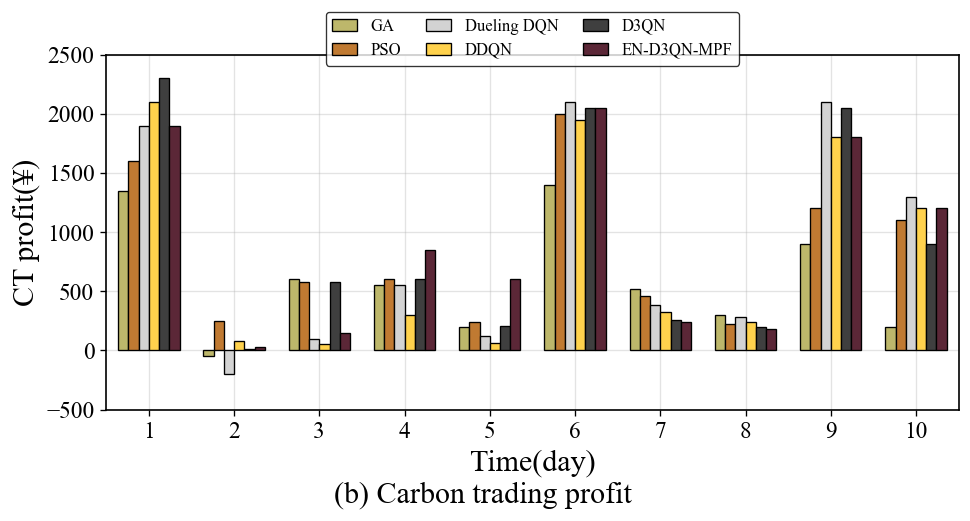

In [2]:
# Reproduce the provided bar chart with matching style (colors, fonts, labels, legend).
# Note: Data below is a placeholder to demonstrate the exact styling; replace with your real values if needed.

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import font_manager

# Try to use Times New Roman; fall back to STIX if unavailable
available_fonts = {f.name for f in font_manager.fontManager.ttflist}
preferred_font = "Times New Roman" if "Times New Roman" in available_fonts else "STIXGeneral"

plt.rcParams.update({
    "font.family": preferred_font,
    "mathtext.fontset": "stix",
    "axes.labelsize": 18,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "axes.spines.top": True,
    "axes.spines.right": True,
})

# X-axis (days)
x = np.arange(1, 11)

# Placeholder data inferred/approximated from the image (adjust as you like)
GA   = np.array([1350,  -50, 600, 550, 200, 1400, 520, 300, 900, 200])
PSO  = np.array([1600,  250, 580, 600, 240, 2000, 460, 220, 1200, 1100])
Duel = np.array([1900, -200, 100, 550, 120, 2100, 380, 280, 2100, 1300])
DDQN = np.array([2100,   80,  50, 300,  60, 1950, 320, 240, 1800, 1200])
D3QN = np.array([2300,   10, 580, 600, 210, 2050, 260, 200, 2050, 900])
EN   = np.array([1900,   30, 150, 850, 600, 2050, 240, 180, 1800, 1200])

series = [GA, PSO, Duel, DDQN, D3QN, EN]
labels = ["GA", "PSO", "Dueling DQN", "DDQN", "D3QN", "EN-D3QN-MPF"]

# Colors approximated to match the visual palette in the image
colors = [
    "#BDB76B",  # GA - DarkKhaki-like
    "#C07A32",  # PSO - warm brown
    "#D3D3D3",  # Dueling DQN - light gray
    "#FFD24D",  # DDQN - rich yellow
    "#3F3F3F",  # D3QN - dark gray
    "#5B2737",  # EN-D3QN-MPF - deep maroon/plum
]

# Plot
fig, ax = plt.subplots(figsize=(8.26, 5.10), dpi=120)

bar_width = 0.12
offsets = np.array([-0.30, -0.18, -0.06, 0.06, 0.18, 0.30])

containers = []
for i, (y, lab, col) in enumerate(zip(series, labels, colors)):
    bars = ax.bar(x + offsets[i], y, width=bar_width,
                  label=lab, color=col, edgecolor="black", linewidth=0.8, zorder=3)
    containers.append(bars)

# Axes labels and limits
ax.set_xlabel("Time(day)")
ax.set_ylabel("CT profit(¥)")
ax.set_xlim(0.5, 10.5)
ax.set_ylim(-500, 2500)
ax.set_xticks(x)

# Grid (both directions to match vertical and horizontal gridlines in the image)
ax.grid(True, which="major", axis="both", linestyle="-", linewidth=0.8, alpha=0.35, zorder=0)

# Ticks to match the -500..2500 range step 500
ax.set_yticks(np.arange(-500, 2501, 500))

# Legend (two rows, centered at the top inside the axes)
leg = ax.legend(ncol=3, loc="upper center", bbox_to_anchor=(0.5, 1.12),
                frameon=True, borderaxespad=0.0, handlelength=1.5, columnspacing=1.5)
leg.get_frame().set_facecolor("white")
leg.get_frame().set_edgecolor("black")
leg.get_frame().set_linewidth(0.8)

# Slightly stronger axis spines to mimic the figure look
for spine in ax.spines.values():
    spine.set_linewidth(1.0)

# Caption below the axes: "(b) Carbon trading profit"
fig.subplots_adjust(top=0.80, bottom=0.22, left=0.12, right=0.98)
fig.text(0.5, 0.08, "(b) Carbon trading profit", ha="center", va="center", fontsize=18, family=preferred_font)

# Save to file
out_path = "/mnt/data/carbon_trading_profit.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()

out_path
